# Assignment 1
\- Si Nguyen Mai, May 12, 2018 -

In [1]:
# for reading data
import pandas as pd
import numpy as np

In [2]:
my_dataset = pd.read_csv('assignment-1_dataset.csv')
my_dataset.head()

,key,energy,liveliness,tempo,speechiness,acousticness,instrumentalness,time_signature,duration,loudness,...,sexual,soothing,spacey,sprightly,sweet,trashy,trippy,visceral,warm,genres
0,11.0,0.912744,0.083704,132.069,0.293137,0.005423,0.000001,0.0,4.0,218.30667,...,0,0,0,0,0,0,0,0,0,pop
1,6.0,0.745704,0.119955,100.008,0.046255,0.026230,0.012727,1.0,4.0,235.06086,...,0,0,0,0,0,0,0,0,0,pop
2,5.0,0.709932,0.231455,130.030,0.121741,0.036662,0.000000,0.0,4.0,232.46104,...,0,0,0,0,0,0,0,0,0,NaN
3,3.0,0.705822,0.053292,126.009,0.126016,0.001966,0.000000,0.0,4.0,194.09333,...,0,0,0,0,0,0,0,0,0,dance
4,3.0,0.741757,0.072774,129.985,0.051255,0.096732,0.000474,0.0,4.0,285.42667,...,0,0,0,0,0,0,0,0,0,reggaeton


In [3]:
audioFeatures_names = ['key', 'energy', 'liveliness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 
                  'time_signature', 'duration', 'loudness', 'valence', 'danceability', 'mode', 
                  'time_signature_confidence', 'tempo_confidence', 'key_confidence', 'mode_confidence']

In [5]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [135]:
def makeInput (classes, features_names, balancing = None, fillna = True, scaler = MinMaxScaler(), rand_seed = 777):
    """
    Return a dictionary `output` with:
        `output['df']` is the data frame with columns of features data (pre-scaled) and target values (genres),
        `output['scaled_features']` is a matrix of scaled features data, the default scaling method is MinMaxScaler, and
        `output['target_values']` is the column `genres` of `output['df']`
    
    Data for multiple genres can be generated by defining `classes` as a list of desired genres.
    Sample size for each class is stored in `class_sizes` and is print out.
    
    Defining balancing with either 'min' or `median` sets the threshold for performing randomly sub-sampling data
    as minimum or median of sample sizes among genres, respectively.
    For any genre with number of songs larger than this threshold, only a random subset of its data is returned
    with size equal to the threshold.
    
    By default, `fillna = True`, which means any NA feature data of a genre is replaced by the mean 
    of corresponding feature in that genre. 
    If `fillna = False`, any record containing NA is discarded.
    
    """
    cols = features_names + ['genres']
    df = my_dataset.query('genres in @classes').loc[:, cols].copy()
    
    class_sizes = {genre : len(df[df['genres'] == genre]) for genre in classes}
    print('Sample size for each genre: ', class_sizes)
    
    if balancing is not None:
        
        balanced_df = pd.DataFrame()
        sizes = np.array(list(class_sizes.values()))
        
        if balancing == 'min': 
            new_size = int(np.min(sizes))
        elif balancing == 'median':
            new_size = int(np.median(sizes))
        
        for genre, size in class_sizes.items():
            subset = df.loc[df['genres'] == genre].copy()
            if size > new_size:
                sample_subset = subset.sample(n = new_size, random_state = rand_seed)
                balanced_df = pd.concat([balanced_df, sample_subset], axis = 0)
            else:
                balanced_df = pd.concat([balanced_df, subset], axis = 0)
        
        new_df = balanced_df.reset_index(drop = True)
        balanced_class_sizes = {genre : len(new_df[new_df['genres'] == genre]) for genre in classes}
        print('Sample size for each genre after balancing: ', balanced_class_sizes)
        
    else:
        new_df = df.reset_index(drop = True)
    
    if fillna:
        means = {genre : new_df.loc[new_df['genres'] == genre, features_names].mean(axis = 0, skipna = True)\
                 for genre in classes}
        
        def fill_na(genre, col, val):
            mean = means[genre][col]
            if np.isnan(val):
                return mean
            else:
                return val
        
        for column in features_names:
            new_df[column] = new_df.apply(lambda row: fill_na(row['genres'], column, row[column]), axis = 1)
    
    else: #drop records with unknown feature values
        new_df.dropna(axis = 0, how = 'any', inplace = True)
        new_df.reset_index(drop = True, inplace = True)
        new_class_sizes = {genre : len(new_df[new_df['genres'] == genre]) for genre in classes}
        print('Sample size for each genre after dropping NAs: ', new_class_sizes)
    
    scaled_features = scaler.fit_transform(new_df.drop('genres', axis = 1))
    
    return {'df': new_df,
           'scaled_features': scaled_features,
           'target_values': new_df['genres']}

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
ue

In [8]:
def run_knn(scaled_features, target_values, splitting = 'train_test_split', k = 3, cv = 10, \
            test_size = 0.3, rand_seed = 777):
    
    knn = KNeighborsClassifier(n_neighbors = k)
    
    if splitting == 'cross_validation':
        from sklearn.metrics import precision_score, recall_score, make_scorer
        custom_scorer = {'accuracy' : 'accuracy', 
                 'precision' : make_scorer(precision_score, average = 'micro'), 
                 'recall' : make_scorer(recall_score, average = 'micro')}
        
        scores = cross_validate(knn, scaled_features, target_values, 
                                scoring = custom_scorer, cv = cv, return_train_score=False)
        
        return {'accuracy': np.mean(scores['test_accuracy']),
               'precision': np.mean(scores['test_precision']),
               'recall': np.mean(scores['test_recall'])}
    
    else:
        X_train, X_test, y_train, y_test = train_test_split(scaled_features, target_values, 
                                                            shuffle = True, test_size = test_size, 
                                                            random_state = rand_seed)
        knn.fit(X_train, y_train)
        predictions = knn.predict(X_test)
        
        confus_mat = ConfusionMatrix(list(y_test), list(predictions))
        classifi_report = classification_report(y_test, predictions)
        
        return {'confusion_matrix': confus_mat,
               'classification_report': classifi_report}

## First, let's try with Jazz and Pop, no balancing, and NAs are replaced by mean

In [23]:
jazz_pop = makeInput(['jazz', 'pop'], audioFeatures_names)
jazz_pop['df']

Sample size for each genre:  {'jazz': 2295, 'pop': 901}


,key,energy,liveliness,tempo,speechiness,acousticness,instrumentalness,time_signature,duration,loudness,valence,danceability,mode,time_signature_confidence,tempo_confidence,key_confidence,mode_confidence,genres
0,11.000000,0.912744,0.083704,132.069000,0.293137,0.005423,0.000001,0.000000,4.000000,218.306670,-3.890000,0.752186,0.726920,0.552000,0.541000,1.000000,1.000000,pop
1,6.000000,0.745704,0.119955,100.008000,0.046255,0.026230,0.012727,1.000000,4.000000,235.060860,-7.687000,0.351282,0.691817,0.737000,0.634000,0.796000,1.000000,pop
2,7.000000,0.585564,0.108297,120.014000,0.038924,0.011707,0.000005,1.000000,4.000000,193.573330,-6.583000,0.622176,0.781822,0.970000,0.861000,0.792000,1.000000,pop
3,4.000000,0.814030,0.079196,124.991000,0.072440,0.005355,0.000000,1.000000,4.000000,198.253330,-1.985000,0.838512,0.700860,0.429000,0.375000,0.740000,1.000000,pop
4,8.000000,0.869554,0.107945,124.065000,0.051083,0.132712,0.000000,1.000000,4.000000,227.973330,-3.739000,0.639499,0.636239,0.239000,0.416000,0.669000,1.000000,pop
5,5.000000,0.838853,0.161256,109.007000,0.043218,0.014582,0.000000,1.000000,4.000000,220.280000,-5.426000,0.456284,0.636132,0.459000,0.454000,0.577000,0.995000,pop
6,1.000000,0.625657,0.418317,80.082000,0.034819,0.003484,0.000000,0.000000,4.000000,230.253330,-7.264000,0.486710,0.585064,0.440000,0.613000,0.000000,1.000000,pop
7,9.000000,0.323877,0.109264,135.116000,0.027887,0.893351,0.000000,1.000000,4.000000,285.266670,-8.237000,0.297851,0.561547,0.358000,0.526000,0.465000,0.720000,pop
8,3.000000,0.640167,0.051898,127.963000,0.049790,0.029364,0.008626,0.000000,4.000000,214.147350,-7.490000,0.684089,0.846949,0.000000,0.245000,0.858000,1.000000,pop
9,5.065312,0.678972,0.204267,119.359716,0.071590,0.211608,0.027756,0.716981,3.973875,234.126035,-7.453633,0.584708,0.628267,0.501251,0.520515,0.553874,0.933862,pop


### Data is splitted by `train_test_split` with test data fraction = 30%

#### trying different number of k-neighbors

In [11]:
for neighbors in range(5, 11):
    jazz_pop_result = run_knn(jazz_pop['scaled_features'], jazz_pop['target_values'], k = neighbors)
    print('When k = ', neighbors)
    print(jazz_pop_result['confusion_matrix'])
    print('\n')
    print(jazz_pop_result['classification_report'])

When k =  5
     |   j     |
     |   a   p |
     |   z   o |
     |   z   p |
-----+---------+
jazz |<637> 31 |
 pop |  44<247>|
-----+---------+
(row = reference; col = test)



             precision    recall  f1-score   support

       jazz       0.94      0.95      0.94       668
        pop       0.89      0.85      0.87       291

avg / total       0.92      0.92      0.92       959

When k =  6
     |   j     |
     |   a   p |
     |   z   o |
     |   z   p |
-----+---------+
jazz |<646> 22 |
 pop |  59<232>|
-----+---------+
(row = reference; col = test)



             precision    recall  f1-score   support

       jazz       0.92      0.97      0.94       668
        pop       0.91      0.80      0.85       291

avg / total       0.92      0.92      0.91       959

When k =  7
     |   j     |
     |   a   p |
     |   z   o |
     |   z   p |
-----+---------+
jazz |<639> 29 |
 pop |  40<251>|
-----+---------+
(row = reference; col = test)



             precision    r

### Using cross validation, try with different number of folds, pick k = 9

In [ ]:
jazz_pop_cv_result = {}

for fold in [10, 50, 100, 200, 500]:
    result = run_knn(jazz_pop['scaled_features'], jazz_pop['target_values'],
                         splitting = 'cross_validation', cv = fold, k = 9)
    jazz_pop_cv_result[fold] = result

In [27]:
for fold in [600, 700, 800, 900]:
    result = run_knn(jazz_pop['scaled_features'], jazz_pop['target_values'],
                         splitting = 'cross_validation', cv = fold, k = 9)
    jazz_pop_cv_result[fold] = result
    
jazz_pop_cv_result

{10: {'accuracy': 0.92711677177023211,
  'precision': 0.92711677177023211,
  'recall': 0.92711677177023211},
 50: {'accuracy': 0.92775717338217323,
  'precision': 0.92775717338217323,
  'recall': 0.92775717338217323},
 100: {'accuracy': 0.92809353616813295,
  'precision': 0.92809353616813295,
  'recall': 0.92809353616813295},
 200: {'accuracy': 0.92857720588235315,
  'precision': 0.92857720588235315,
  'recall': 0.92857720588235315},
 500: {'accuracy': 0.92911428571428578,
  'precision': 0.92911428571428578,
  'recall': 0.92911428571428578},
 600: {'accuracy': 0.93044444444444441,
  'precision': 0.93044444444444441,
  'recall': 0.93044444444444441},
 700: {'accuracy': 0.93152380952380964,
  'precision': 0.93152380952380964,
  'recall': 0.93152380952380964},
 800: {'accuracy': 0.92887500000000001,
  'precision': 0.92887500000000001,
  'recall': 0.92887500000000001},
 900: {'accuracy': 0.92783333333333329,
  'precision': 0.92783333333333329,
  'recall': 0.92783333333333329}}

### Also Jazz and Pop, no balancing, but any record with NA is dropped 

In [13]:
jazz_pop_reduced = makeInput(['jazz', 'pop'], audioFeatures_names, fillna = False)

for neighbors in range(5, 12):
    jazz_pop_reduced_result = run_knn(jazz_pop_reduced['scaled_features'], jazz_pop_reduced['target_values'], 
                                      k = neighbors)
    print('When k = ', neighbors)
    print('\n')
    print(jazz_pop_reduced_result['confusion_matrix'])
    print('\n')
    print(jazz_pop_reduced_result['classification_report'])

Sample size for each genre:  {'jazz': 2295, 'pop': 901}
Sample size for each genre after dropping NAs:  {'jazz': 1889, 'pop': 689}
When k =  5


     |   j     |
     |   a   p |
     |   z   o |
     |   z   p |
-----+---------+
jazz |<530> 38 |
 pop |  44<162>|
-----+---------+
(row = reference; col = test)



             precision    recall  f1-score   support

       jazz       0.92      0.93      0.93       568
        pop       0.81      0.79      0.80       206

avg / total       0.89      0.89      0.89       774

When k =  6


     |   j     |
     |   a   p |
     |   z   o |
     |   z   p |
-----+---------+
jazz |<541> 27 |
 pop |  51<155>|
-----+---------+
(row = reference; col = test)



             precision    recall  f1-score   support

       jazz       0.91      0.95      0.93       568
        pop       0.85      0.75      0.80       206

avg / total       0.90      0.90      0.90       774

When k =  7


     |   j     |
     |   a   p |
     |   z   o |
     |  

In [14]:
jazz_pop_reduced_cvResult = run_knn(jazz_pop_reduced['scaled_features'], jazz_pop_reduced['target_values'],
                         splitting = 'cross_validation', k = 9)
print(jazz_pop_reduced_cvResult)

{'accuracy': 0.91233042635658923, 'precision': 0.91233042635658923, 'recall': 0.91233042635658923}


**Simply dropped NAs reduces sample size and might decrease performance of prediction**

## Add Rock songs, no balancing

In [29]:
jazz_pop_rock = makeInput(['jazz', 'pop', 'rock'], audioFeatures_names)

Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}


In [30]:
for neighbors in [5, 10, 15, 20, 30, 40]:
    result = run_knn(jazz_pop_rock['scaled_features'], jazz_pop_rock['target_values'],
                         splitting = 'cross_validation', cv = 700, k = neighbors)
    print('For k =', neighbors, result)

For k =  5 {'accuracy': 0.83533533413365346, 'precision': 0.83533533413365346, 'recall': 0.83533533413365346}
For k =  10 {'accuracy': 0.84532007803121267, 'precision': 0.84532007803121267, 'recall': 0.84532007803121267}
For k =  15 {'accuracy': 0.84871468587434984, 'precision': 0.84871468587434984, 'recall': 0.84871468587434984}
For k =  20 {'accuracy': 0.84795098039215677, 'precision': 0.84795098039215677, 'recall': 0.84795098039215677}
For k =  30 {'accuracy': 0.84715661264505793, 'precision': 0.84715661264505793, 'recall': 0.84715661264505793}
For k =  40 {'accuracy': 0.84893027210884353, 'precision': 0.84893027210884353, 'recall': 0.84893027210884353}


## Add Rock songs, with balancing

In [14]:
b_jazz_pop_rock = []
for seed in range(10):
    data = makeInput(['jazz', 'pop', 'rock'], audioFeatures_names, balancing = 'median', rand_seed = seed)
    b_jazz_pop_rock.append(data)

Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 7485}
Sample size for each genre after balancing:  {'jazz': 2295, 'pop': 901, 'rock': 2295}
Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'rock': 

In [35]:
b_jazzPopRock_result = []

for data in b_jazz_pop_rock:
    for neighbors in [5, 10, 20, 50, 100]:
        result = run_knn(data['scaled_features'], data['target_values'],
                         splitting = 'cross_validation', cv = 700, k = neighbors)
        list_output = [result['accuracy'], result['precision'], result['recall'], neighbors]
        b_jazzPopRock_result.append(list_output)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [38]:
cols = ['accuracy', 'precision', 'recall', 'k']
b_jazzPopRock_cvResults = pd.DataFrame(b_jazzPopRock_result, columns = cols)
b_jazzPopRock_cvResults.head()

,accuracy,precision,recall,k
0,0.795939,0.795939,0.795939,5
1,0.802990,0.802990,0.802990,10
2,0.808781,0.808781,0.808781,20
3,0.805546,0.805546,0.805546,50
4,0.801291,0.801291,0.801291,100


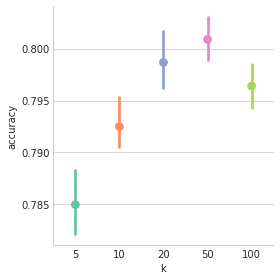

In [42]:
sns.factorplot(x = 'k', y = 'accuracy', data = b_jazzPopRock_cvResults, palette="Set2")
plt.show()

## Replace Rock by Dance

In [33]:
jazz_pop_dance = makeInput(['jazz', 'pop', 'dance'], audioFeatures_names)
jazz_pop_dance_result = run_knn(jazz_pop_dance['scaled_features'], jazz_pop_dance['target_values'], 
                                splitting = 'cross_validation', cv = 500, k = 10)
print(jazz_pop_dance_result)

Sample size for each genre:  {'jazz': 2295, 'pop': 901, 'dance': 2391}
{'accuracy': 0.85187070707070711, 'precision': 0.85187070707070711, 'recall': 0.85187070707070711}


## Different set of genres: Rock and Jazz

In [94]:
rock_jazz = makeInput(['rock', 'jazz'], audioFeatures_names)

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}


In [95]:
rock_jazz_result = run_knn(rock_jazz['scaled_features'], rock_jazz['target_values'], k = 20)
print(rock_jazz_result['classification_report'])

             precision    recall  f1-score   support

       jazz       0.77      0.81      0.79       687
       rock       0.94      0.92      0.93      2247

avg / total       0.90      0.90      0.90      2934



In [96]:
rock_jazz_cvResult = run_knn(rock_jazz['scaled_features'], rock_jazz['target_values'], 
                            splitting = 'cross_validation', cv = 500, k = 20)

print(rock_jazz_cvResult)

{'accuracy': 0.90192222222222218, 'precision': 0.90192222222222218, 'recall': 0.90192222222222218}


### ... and again, simply dropping records with NA reduces prediction performance

In [97]:
rock_jazz_reduced = makeInput(['rock', 'jazz'], audioFeatures_names, fillna = False)
rock_jazz_reduced_result = run_knn(rock_jazz_reduced['scaled_features'], rock_jazz_reduced['target_values'], k = 20)
print(rock_jazz_reduced_result['classification_report'])

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}
Sample size for each genre after dropping NAs:  {'rock': 6435, 'jazz': 1889}
             precision    recall  f1-score   support

       jazz       0.71      0.77      0.74       563
       rock       0.93      0.91      0.92      1935

avg / total       0.88      0.88      0.88      2498



### try with balancing

In [138]:
b_rock_jazz = makeInput(['rock', 'jazz'], audioFeatures_names, balancing = 'min')
b_rock_jazz_cvResult = run_knn(b_rock_jazz['scaled_features'], b_rock_jazz['target_values'], 
                            splitting = 'cross_validation', cv = 500, k = 20)

print(b_rock_jazz_cvResult)

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}
Sample size for each genre after balancing:  {'rock': 2295, 'jazz': 2295}
{'accuracy': 0.8801500000000001, 'precision': 0.8801500000000001, 'recall': 0.8801500000000001}


In [139]:
b_rock_jazz = makeInput(['rock', 'jazz'], audioFeatures_names, balancing = 'median')
b_rock_jazz_cvResult = run_knn(b_rock_jazz['scaled_features'], b_rock_jazz['target_values'], 
                            splitting = 'cross_validation', cv = 500, k = 20)

print(b_rock_jazz_cvResult)

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}
Sample size for each genre after balancing:  {'rock': 4890, 'jazz': 2295}
{'accuracy': 0.89019633699633705, 'precision': 0.89019633699633705, 'recall': 0.89019633699633705}


### try with different set of audio features

In [102]:
features_list = ['energy', 'tempo', 'speechiness', 'acousticness', 'loudness', 'valence', 'danceability', 'mode', 
                  'tempo_confidence', 'mode_confidence']

In [122]:
new_rock_jazz = makeInput(['rock', 'jazz'], features_list)
new_rock_jazz['df'].head()

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}


,energy,tempo,speechiness,acousticness,loudness,valence,danceability,mode,tempo_confidence,mode_confidence,genres
0,0.398953,77.821,0.033343,0.007855,548.03156,-19.753,0.243535,0.198917,0.676,0.996,rock
1,0.906388,127.438,0.122818,0.000353,210.42667,-5.856,0.318454,0.418888,0.602,0.889,rock
2,0.699017,140.624,0.038933,0.158435,471.20000,-7.392,0.725072,0.439839,0.542,0.691,rock
3,0.870259,110.075,0.042160,0.003531,187.52000,-4.185,0.221896,0.488180,0.475,0.793,rock
4,0.738028,119.004,0.030686,0.157794,235.28000,-3.918,0.317212,0.610500,0.579,0.950,rock


In [104]:
new_rock_jazz_result = run_knn(new_rock_jazz['scaled_features'], new_rock_jazz['target_values'], k = 20)
print(new_rock_jazz_result['classification_report'])

             precision    recall  f1-score   support

       jazz       0.76      0.79      0.78       687
       rock       0.94      0.93      0.93      2247

avg / total       0.90      0.89      0.89      2934



### try with mood feature

In [7]:
mood_features = my_dataset.drop(audioFeatures_names + ['genres'], axis = 1)
mood_features

,aggressive,angsty,atmospheric,campy,celebratory,classy,cocky,cold,earthy,energetic,...,seductive,sexual,soothing,spacey,sprightly,sweet,trashy,trippy,visceral,warm
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
moods = list(mood_features.columns.values)
mood_rock_jazz = makeInput(['rock', 'jazz'], moods)

Sample size for each genre:  {'rock': 7485, 'jazz': 2295}


In [129]:
mood_rock_jazz_result = run_knn(mood_rock_jazz['scaled_features'], mood_rock_jazz['target_values'], 
                                k = 20)
print(mood_rock_jazz_result['classification_report'])

             precision    recall  f1-score   support

       jazz       0.94      0.81      0.87       687
       rock       0.94      0.98      0.96      2247

avg / total       0.94      0.94      0.94      2934

